# Lorenz SBI V2

This notebook incorporates the whole workflow of the Lorenz example on the GitHub of krisevers. The goal of this notebook is to put all the different files into 1 file and display all figures and comments into 1 notebook for convenience purposes.

First import the needed libaries.

In [1]:
import os
import numpy as np
import pylab as plt
import argparse 

import torch
import sbi.utils as utils
from sbi.inference import SNPE, SNLE, SNRE
from sbi.analysis import pairplot, conditional_pairplot
from lorenz import lorenz, statistics
from scipy.integrate import odeint
from utils import marginal_correlation

# If needed, before starting, change the current working directory by uncommenting and inserting the right path in the following line of code.
#os.chdir("/home/coder/projects/lorenz_sbi")

# Throughout the code I inserted the path that I want to files saved in or taken from. Change this to your own path before starting!

/home/coder/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-04 08:20:50.563942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 08:20:51.224867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Effect of noise in the summary statistics on the result

The noise_matrix is still stochaistic so every time you run this code new values will be generated (set a seed otherwise!)

In [45]:
# Load the X matrix.
data_X = np.load("/home/coder/projects/lorenz_sbi/data/X.npy")
print("The shape of X is: ", data_X.shape)
print("The first row of X without noise: ", "\n", data_X[0])

# First create noise matrix that has the same size as (data_)X matrix.
# random.randn() returns "random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1."
# Use a seed when you want the same outcome everytime!
rows_X, columns_X = data_X.shape

# Add noise to summary statistics (in Lorenz example, len of X is 24, where the last 3 columns contain the parameters)
# so the first 21 columns contain summary statistics.
noise_matrix = np.random.randn(rows_X, 21)

# Don't add noise to the parameters.
matrix_with_zeros = np.zeros(shape = (rows_X, 3))

# Create noise_matrix with the right size so it can be added up to the (data_)X matrix.
noise_matrix = np.concatenate((noise_matrix, matrix_with_zeros), axis = 1)

# Add noise to (data_)X.
summ_stats_with_noise = data_X + noise_matrix

# Replace the negative values in the resulting matrix with 0 as the summary stats can't be negative.
summ_stats_with_noise[summ_stats_with_noise < 0] = 0

print("The first row of (data_)X + noise values: ", "\n", summ_stats_with_noise[0])

# Save new X.
np.save("/home/coder/projects/lorenz_sbi/data/X_with_noise", summ_stats_with_noise)

The shape of X is:  (60000, 24)
The first row of X without noise:  
 [5.91164975 5.91920401 5.96471115 0.13882868 0.11480275 0.1577574
 0.11480275 0.10333426 0.11946977 0.1577574  0.11946977 0.19903269
 1.         0.95849652 0.94904747 0.95849652 1.         0.83305496
 0.94904747 0.83305496 1.         8.50382875 5.87806224 7.00083841]
The first row of (data_)X + noise values:  
 [6.41574094 5.75288327 6.12152806 0.34466616 0.         2.33946268
 0.         0.35347831 0.16601168 0.26545085 0.         0.
 1.58301294 0.         1.06832166 1.29629101 1.31441064 0.35368095
 1.86574163 1.42343205 0.52340075 8.50382875 5.87806224 7.00083841]


The following code is derived from train.py in the original GitHub repository.

In [46]:
def train(num_simulations,
          x, 
          theta,
          num_threads=1,
          method="SNPE",
          device="cpu",
          density_estimator="maf"):
    
    torch.set_num_threads(num_threads)

    if (len(x.shape) == 1):
        x = x[:, None]
    if (len(theta.shape) == 1):
        theta = theta[:, None]


    if (method == "SNPE"):
        inference = SNPE(
            density_estimator=density_estimator, device=device
        )
    elif (method == "SNLE"):
        inference = SNLE(
            density_estimator=density_estimator, device=device
        )
    elif (method == "SNRE"):
        inference = SNRE(
            density_estimator=density_estimator, device=device
        )
    else:
        raise ValueError("Unknown inference method")
    
    inference = inference.append_simulations(theta, x)
    _density_estimator = inference.train()
    posterior = inference.build_posterior(_density_estimator)

    return posterior

def infer(obs_stats,
          num_samples,
          posterior):
    return posterior.sample((num_samples,), x=obs_stats)

parser = argparse.ArgumentParser(description="Train a density estimator on the Lorenz system.")
# Insert own path if needed.
parser.add_argument("--data", type=str, default="/home/coder/projects/lorenz_sbi/data/X_with_noise.npy", help="Path to the data file.")
parser.add_argument("--method", type=str, default="SNPE", help="Inference method.")
parser.add_argument("--density_estimator", type=str, default="maf", help="Density estimator.")
parser.add_argument("--num_threads", type=int, default=1, help="Number of threads.")
parser.add_argument("--device", type=str, default="cpu", help="Device.")

#args = parser.parse_args()

# According to Stackoverflow change the above line to:
args, unknown = parser.parse_known_args()

X = np.load(args.data, allow_pickle=True)

params = X[:, -3:]
stats  = X[:, :-3]

num_simulations = X.shape[0]

theta = torch.from_numpy(params).float()
x = torch.from_numpy(stats).float()

# Neural network converges after 142 epochs the first time.
posterior = train(num_simulations,
                    x,
                    theta,
                    num_threads         = args.num_threads,
                    method              = args.method,
                    device              = args.device,
                    density_estimator   = args.density_estimator
                    )

# Save posterior.
# Insert own path if needed.
torch.save(posterior, "/home/coder/projects/lorenz_sbi/models/posterior_with_noise.pt")

 Neural network successfully converged after 128 epochs.

The following code is derived from posterior.py from the original GitHub repository.
The original parameters were: σ = 10, β = 8/3 and ρ = 28.

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:01<00:00, 85837.76it/s]


<Figure size 640x480 with 0 Axes>

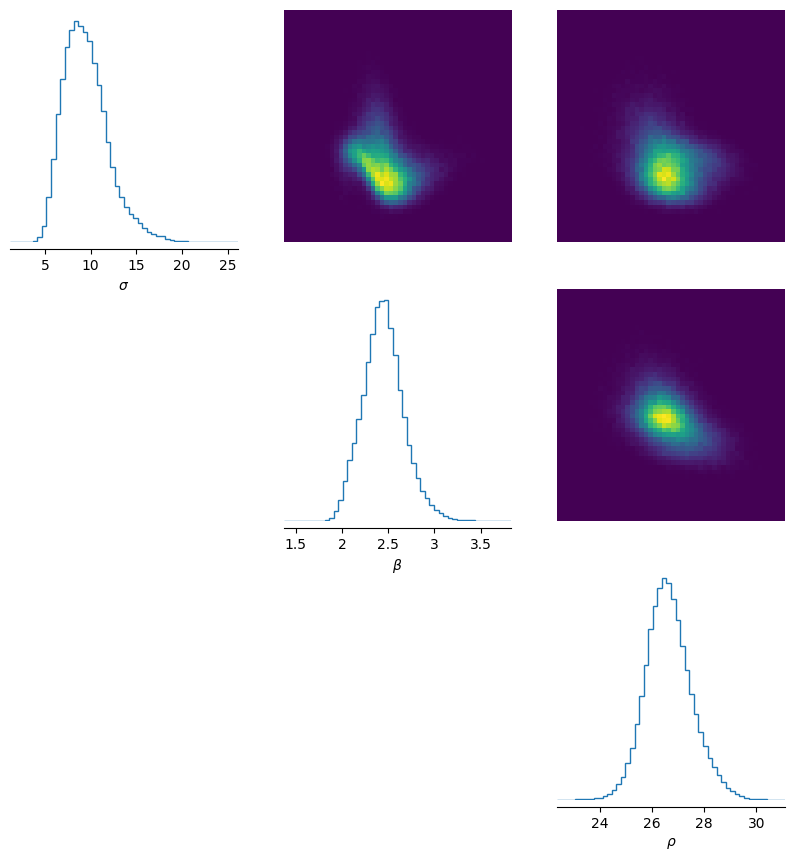

<Figure size 640x480 with 0 Axes>

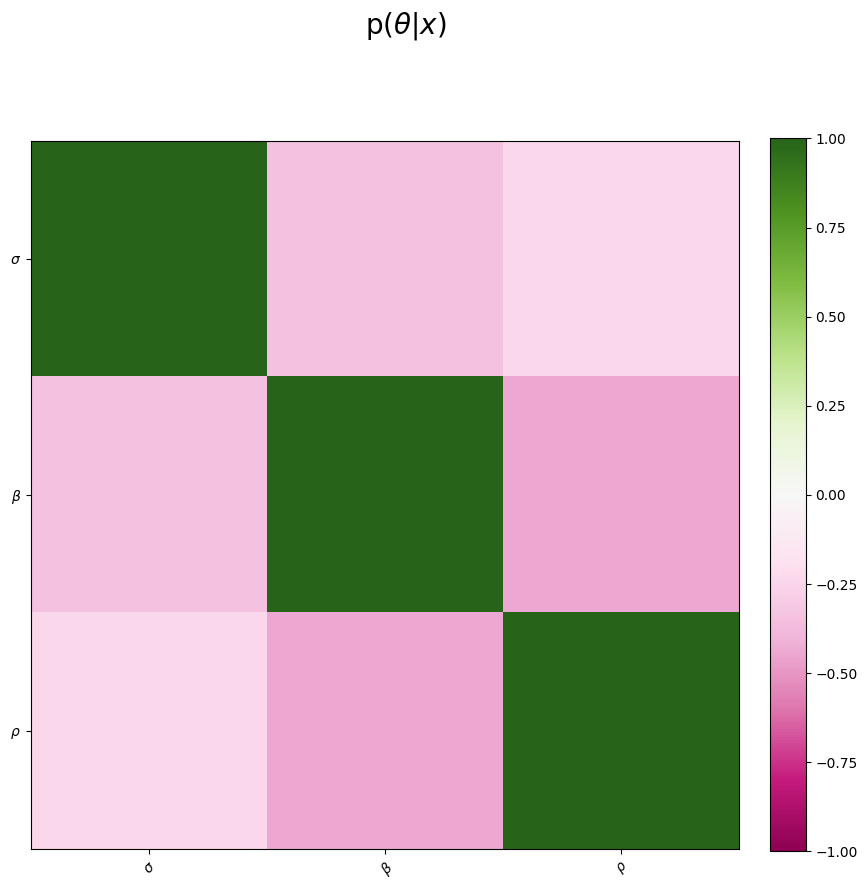

In [47]:
# Set the Lorenz parameters.
sigma = 10.0
beta  = 8.0 / 3.0
rho   = 28.0

# Set the initial condition.
x0 = np.array([0.0, 1.0, 1.05])

# Set the time sample.
t = np.linspace(0.0, 100.0, 1000)

# Solve the ODE.
x_t = odeint(lorenz, x0, t, args=(sigma, beta, rho))

mean, cov, cor, eigvals, eigvecs, lyap = statistics(x_t)

obs_x = np.concatenate([mean, cov.flatten(), cor.flatten()])
obs_theta = [sigma, beta, rho]

# Load posterior.
# Insert own path if needed.
posterior = torch.load("/home/coder/projects/lorenz_sbi/models/posterior_with_noise.pt")

num_samples = 100000

posterior.set_default_x(obs_x)
posterior_samples = posterior.sample((num_samples,))

plt.figure()
#true_params = [sigma, beta, rho]
fig, ax = pairplot(samples=posterior_samples, labels=[r"$\sigma$", r"$\beta$", r"$\rho$"], figsize=(10, 10))
#fig, ax = pairplot(samples=posterior_samples, figsize=(10, 10), points=true_params, points_colors= "r")
plt.show()

plt.figure()
fig, ax = marginal_correlation(samples=posterior_samples, labels=[r"$\sigma$", r"$\beta$", r"$\rho$"], figsize=(10, 10))
plt.show()